# Semantic segmentation with backbone

In [1]:
!pip install segmentation-models --quiet
!pip install mycolorpy --quiet
!pip install tensorflow-addons --quiet
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
from cv2 import Sobel, Laplacian, watershed
import cv2 as cv
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp


#from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

from keras.layers import Input, Conv2D
from keras.models import Model


import tensorflow as tf
from tensorflow.keras import backend as K
from unet_detection.models.vanilla_unet import vanilla_unet

# Load data

In [4]:
X_train = np.load("data/spec_lib/X_data.npy") 
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [5]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [6]:
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1], y_test.shape[2], 1))

In [7]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(150, 128, 128, 11)
(20, 128, 128, 11)
(24, 128, 128, 11)


# Set up metrics/loss

In [8]:
def multi_mcc_loss(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m)))
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    
    return 1 - K.mean(mcc)

def multi_mcc(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    #y_true = tf.convert_to_tensor(y_true)
    #y_pred = tf.convert_to_tensor(y_pred)
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m))) 
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    return K.mean(mcc)


# Set up model

In [9]:
#base_model = sm.Unet(backbone_name='resnet34', encoder_weights='imagenet',
#                     classes=11, activation='softmax', encoder_freeze=True)

#inp = Input(shape=(128, 128, 399))
#l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
#out = base_model(l1)

#model = Model(inp, out, name=base_model.name)

model = sm.Unet(backbone_name='resnet18', encoder_weights=None, input_shape=(128, 128, 399),
                classes=11, activation='softmax')

In [10]:
from segmentation_models.losses import CategoricalFocalLoss
from sklearn.metrics import matthews_corrcoef

loss = CategoricalFocalLoss()

f1 = tfa.metrics.F1Score(num_classes=11, average='micro')
model.compile(optimizer='adam',
                loss=loss,
                metrics=[f1, multi_mcc])

In [11]:
h = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=50)

Epoch 1/50
5/5 [==============================] - 27s 3s/step - loss: 0.0414 - f1_score: 0.1984 - multi_mcc: 0.0124 - val_loss: 0.3491 - val_f1_score: 0.0468 - val_multi_mcc: -0.0055
Epoch 2/50
5/5 [==============================] - 4s 730ms/step - loss: 0.0265 - f1_score: 0.6185 - multi_mcc: 0.0436 - val_loss: 0.3451 - val_f1_score: 0.0578 - val_multi_mcc: -6.4896e-04
Epoch 3/50
5/5 [==============================] - 4s 728ms/step - loss: 0.0180 - f1_score: 0.7705 - multi_mcc: 0.0703 - val_loss: 0.2771 - val_f1_score: 0.2435 - val_multi_mcc: 0.0120
Epoch 4/50
5/5 [==============================] - 4s 730ms/step - loss: 0.0128 - f1_score: 0.8326 - multi_mcc: 0.0984 - val_loss: 0.2512 - val_f1_score: 0.3142 - val_multi_mcc: -0.0230
Epoch 5/50
5/5 [==============================] - 4s 738ms/step - loss: 0.0097 - f1_score: 0.8600 - multi_mcc: 0.1245 - val_loss: 0.1973 - val_f1_score: 0.4612 - val_multi_mcc: -0.0229
Epoch 6/50
5/5 [==============================] - 4s 733ms/step - loss: 0.

Text(0.5, 1.0, 'scorings')

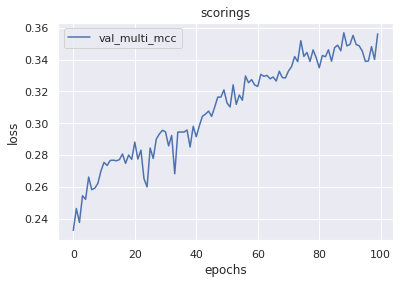

In [35]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][50:]) for key in ['val_multi_mcc']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("scorings")

Text(0.5, 1.0, 'scorings')

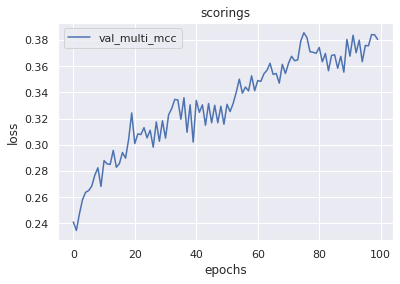

In [16]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][50:]) for key in ['val_multi_mcc']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("scorings")

In [53]:
from keras.layers import Input
u = vanilla_unet()

img1 = Input(shape=(128,128,399))

model = u.get_unet(img1, None, n_classes=11, last_activation='softmax')

from segmentation_models.losses import CategoricalFocalLoss

loss = CategoricalFocalLoss()

f1 = tfa.metrics.F1Score(num_classes=11, average='micro')
model.compile(optimizer='adam',
                loss=loss,
                metrics=[f1, multi_mcc])

In [54]:
h = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=15)

InternalError: ignored

# Show pred data

In [17]:
rød = X_test[:,:,:,81]; grønn = X_test[:,:,:,46]; blå = X_test[:,:,:,21];
rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.array(rgb)

nx = 6
ny = 4

def arange_image(img):
  u = []
  o = 0
  for i in range(int(nx)):
    b = np.array(img[o])
    o += 1
    for j in range(1,int(ny)):
      b = np.append(b, img[o], axis=1)
      o += 1
                  
    if len(u) == 0:
      u = b
    else:
      u = np.append(u, b, axis=0)
  return u


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediciton')

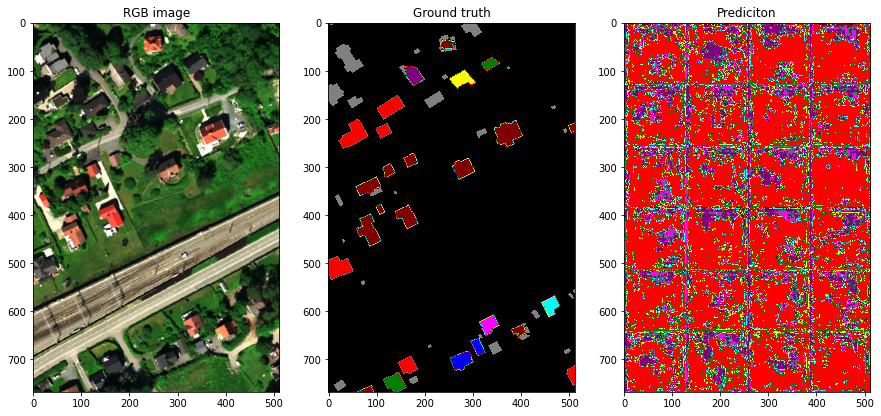

In [18]:
classes = ["None", "unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
           "red concrete", "gravel", "green ceramic", "pcv", "tar roofing paper"]

colormap = ListedColormap(["black", "gray", "red", "green", "yellow", "cyan", "maroon",
                           "magenta", "seagreen", "purple", "blue"])

y = y_test.argmax(axis=3)
pred = model.predict(X_test)
p = np.argmax(pred,axis=3)

u = arange_image(rgb)
v = arange_image(y)
w = arange_image(p)

w[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]

sns.reset_orig()
fig, (ax0, ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
im1 = ax0.imshow(u/2500); ax0.set_title("RGB image")
im1 = ax1.imshow(v, cmap=colormap); ax1.set_title("Ground truth")
im1 = ax2.imshow(w, cmap=colormap); ax2.set_title("Prediciton")

#With resnet as encoder/decoder
